<a href="https://colab.research.google.com/github/CostiaB/AI4D-Malawi-News-Classification-Challenge/blob/main/navier_graphs_conc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy
import itertools
import numpy as np
from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from tqdm import tqdm
import gc

In [2]:
!pip install gif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4818 sha256=20b8f09a67b1078fdba899f2eb193758f30fd1893ec52d9a753b430f992803ba
  Stored in directory: /root/.cache/pip/wheels/21/63/09/b1e3c512d244da0a7c1d9565f09592612d04b79ccbb95146ae
Successfully built gif


In [3]:
def channel_shape(field,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value,
                  ny):
    '''
    field - target field
    w - electodes width,
    h - height, 
    d - distance between electrodes,
    s - distance from corner
     
    sizes of correspoding rectangulars in tuples
    (y,x)
    
    bottom_left 
    top_left 
    bottom_right
    
    Values on electrodes
    
    andode_value
    cathode_value
    
    border_value - value on inner channel border
    ny  -  length of the channel
    
    '''
#(y,x)
    
    #rectanguars
    field[0:bottom_left[0]-1, 0:bottom_left[1]-1] = border_value
    field[0:bottom_right[0]-1, bottom_right[1]:] = border_value
    field[ny-top_left[0]:, 0:top_left[1]-1] = border_value
    field[:, (nx-bottom_left[1]):] = border_value

    #right border
    field[bottom_right[0]:-1, -1] = border_value

    #right side of lower part
    field[0:bottom_right[0], bottom_right[1]] = border_value

    #bottom of channel
    field[bottom_right[0], bottom_right[1]:-1] = border_value

    #left border
    field[0:(ny-top_left[0]), bottom_left[1]] = border_value

    #channel top
    field[ny-top_left[0], bottom_left[1]:top_left[1]] = border_value

    #channel top right side
    field[(ny-top_left[0]):-1, top_left[1] ] = border_value

    
    #TO DO add each side to make border
 
    #h>0 or <0
    t = 0
    g = 1
    if h==0:
        h = 1
    elif h<0:
        t = 1
        g = 0
    #top anode
    field[ny-top_left[0]-g*h:ny-top_left[0]-t*h, top_left[1]-s-w:top_left[1]-s] = andode_value
    
    #top cathode
    field[ny-top_left[0]-g*h:ny-top_left[0]-t*h, top_left[1]-s-w-d-w:top_left[1]-s-w-d] = cathode_value

    #bottom anode
    field[bottom_right[0]+t*h:bottom_right[0]+g*h, bottom_right[1]+s:bottom_right[1]+s+w ] = andode_value

    #bottom cathode
    field[bottom_right[0]+t*h:bottom_right[0]+g*h, bottom_right[1]+s+w+d:bottom_right[1]+s+w+d+w ] = cathode_value
    
    return field
   
    

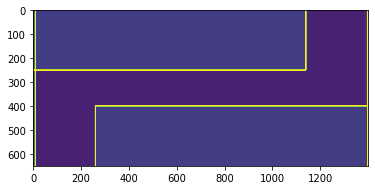

In [4]:
ny, nx = 650, 1400
bottom_left = (650, 10)
bottom_right = (250, 260)
top_left = (250, 1140)
field = np.zeros((ny, nx))
field[0:bottom_left[0], 0:bottom_left[1]] = 1
field[(ny-top_left[0]):ny, 0:top_left[1]] = 1
field[0:bottom_right[0], bottom_right[1]:] = 1
field[0:ny, (nx-bottom_left[1]):] = 1

# a
field[:, bottom_left[1]-1:bottom_left[1]] = 100


# b
field[(ny-top_left[0])-1:(ny-top_left[0]), 0:top_left[1] ] = 100

# c
field[:bottom_right[0], bottom_right[1]:bottom_right[1]+1] = 100

# d
field[bottom_right[0]:bottom_right[0]+1, bottom_right[1]:] = 100


#e
field[ny-top_left[0]:, top_left[1]:top_left[1]+1] = 100

#f
field[:, nx-1:nx] = 100

plt.imshow(field[::-1,:], vmin = -1, vmax = 10)
#plt.imshow(field[::-1,:])

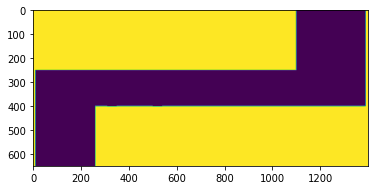

In [5]:
scale = 1
freq = 1



u_gr = []
v_gr = []
p_gr = []



u_gr1 = []
v_gr1 = []
p_gr1 = []

ch_it = []



nx = int((400+300+400+300)/scale)
ny = int((250+150+250)/scale)

field = np.ones((ny, nx))

andode_value = 0
cathode_value = 0
border_value = 0
w = int(40/scale)
h = int(20/scale)
d = int(150/scale)
s = int(50/scale)
bottom_left = (int(650/scale), int(10/scale))
top_left = (int(250/scale), int(1100/scale))
bottom_right = (int(250/scale), int(260/scale))

dx = 1
dy = 1
dt = .01

rho = 1
nu = .1
F = 0.15
P0 = 0.15
D = 0.0002
rho = 1
nu = .0001
c0 = 1
ca = 0.03

c = np.zeros((ny, nx))*0.03
v = np.zeros((ny, nx)) / 100

u = np.zeros((ny, nx)) / 100

p = np.zeros((ny, nx)) / 100000
b = np.zeros((ny, nx)) / 100000


nt = 2000


plt.imshow(channel_shape(p,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value+1,
                  ny)[::-1])

In [6]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = numpy.zeros_like(u)

    b = channel_shape(field=b,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
    
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    return b


def laplace2d_parralel_C0(c, 
                          freq,
                          w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy,
                              P0, stepcount,
                              nit, l1norm_target):
    l1norm = 1
    cn = np.empty_like(c)

    dx2 = dx**2
    dy2 = dy**2

    

    for i in itertools.count(0, 1):
        cn = c.copy()
        c[1:-1, 1:-1] = ((dy2 * (cn[1:-1, 2:] + cn[1:-1, 0:-2]) +
                         dx2 * (cn[2:, 1:-1] + cn[0:-2, 1:-1])) /
                        (2 * (dx2 + dy2)))
            
                 
        
        c = channel_shape(field=c,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
        
        
        
        # border (gradC,n) == 0 
        #x,y = border(w, 0, d,l)
        #c[0, x] = c[1, x]
        
        #c[-1, :] = c[-2, :]  #?????
        
        
        #c[np.where(mask_cathodes==1)] = 0
        #c[np.where(mask_anodes==1)] = ca

           
       
        if i%10 == 0 and i > 1:
            l1norm = np.abs((np.sum(np.abs(c[:]) - np.abs(cn[:])) /
            np.sum(np.abs(cn[:]))))
            if  l1norm < l1norm_target or i >25000:
                #c[np.where(mask_cathodes==1)] = 0
                #c[np.where(mask_anodes==1)] = 0
                print(l1norm)
                break
         

    return c

In [11]:
def pressure_poisson_periodic(p_z, 
                              freq,
                              w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy,
                              P0, stepcount,
                              nit):
    pn = numpy.empty_like(p_z)
    p = p_z.copy()

    dx2 = dx**2
    dy2 = dy**2
    

    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])
        
       
        
        
        p = channel_shape(field=p,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
       
        
        # dp/dy = 0 at top channel border
        p[(ny-top_left[0])- 1:(ny-top_left[0]), 0:top_left[1] ] =  \
               p[(ny-top_left[0])-2:(ny-top_left[0])-1, 0:top_left[1] ]
     
        # dp/dy = 0 at bottom channel border
        p[bottom_right[0]:bottom_right[0]+1, bottom_right[1]:] = \
               p[bottom_right[0]+1:bottom_right[0]+2, bottom_right[1]:]
        # need borders on top level
        #p[-1, :] = p[-2, :]  # dp/dy = 0 at y = 2
        # need borders on bottom level
        #p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
        # need borders on right and left sides
        #p[:, 0] = 0  # p = 0 @ x = 0
        
        #check whether we can implement this condicions via channel shape or 
        #directly thought shape of channel
        
        
        if stepcount==0:
            p[0, bottom_left[1]:bottom_right[1]] = P0*np.cos(2*np.pi*(q*dt)*freq)
            p[-1, top_left[1]:-1] = -P0*np.cos(2*np.pi*(q*dt)*freq)
        else:
            p[0, bottom_left[1]:bottom_right[1]] = P0*np.cos(2*np.pi*(stepcount*dt)*freq)
            p[-1, top_left[1]:-1] = -P0*np.cos(2*np.pi*(stepcount*dt)*freq)   
           
              
    

    return p

In [12]:
def navier_stokes(u, v, freq,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value,
                  ny, nx,
                  p, b,
                  rho, nu, 
                  dt, dx, dy,
                  F, P0, nt):
    
    
    udiff = 1
    
    

   
    stepcount = 1
    #check if p initialization is working
    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p,
                              freq,
                              w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy,
                              P0, stepcount,
                              100)
    stepcount+=1
    for t in range(nt):
        un = u.copy()
        vn = v.copy()
        b = build_up_b(rho, dt, dx, dy, u, v)
        p = pressure_poisson_periodic(p,
                              freq,
                              w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy,
                              P0, stepcount,
                              1)
        

        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                      un[1:-1, 1:-1] * dt / dx * 
                      (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                      vn[1:-1, 1:-1] * dt / dy * 
                      (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                      dt / (2 * rho * dx) * 
                      (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                      nu * (dt / dx**2 * 
                      (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                      dt / dy**2 * 
                      (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                      0*F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                      un[1:-1, 1:-1] * dt / dx * 
                      (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                      vn[1:-1, 1:-1] * dt / dy * 
                      (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                      dt / (2 * rho * dy) * 
                      (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                      nu * (dt / dx**2 *
                      (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                      dt / dy**2 * 
                      (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))


      # Wall  and electrodes BC: u,v = 0 
        v = channel_shape(field=v,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
        u = channel_shape(field=u,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
        
        #v[0, bottom_left[1]:bottom_right[1]] = F*np.cos(2*np.pi*(stepcount*dt)*freq)
        #v[-1, top_left[1]:-1] = -F*np.cos(2*np.pi*(stepcount*dt)*freq) 
        
        print(f'it : {t} p : {p.max()}, u : {u.max()}, v : {v.max()}')
        
        if t%50==0:
            u_gr1.append(u.copy())
            v_gr1.append(v.copy())
            p_gr1.append(p.copy())
        stepcount+=1
      
        udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
        
        
    
    v = channel_shape(field=v,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=0, cathode_value=0,
                  border_value=0,
                  ny=ny)
    
    u = channel_shape(field=u,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=0, cathode_value=0,
                  border_value=0,
                  ny=ny)
    
    return u, v, p

In [13]:
def navier_stokes_for_conc(u, v, freq,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value,
                  ny, nx,
                  p, b,
                  rho, nu, 
                  dt, dx, dy,
                  F, P0, nt=1, step =1):
   
     
    for t in range(nt):
        un = u.copy()
        vn = v.copy()
        b = build_up_b(rho, dt, dx, dy, u, v)
        p = pressure_poisson_periodic(p,
                              freq,
                              w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy,
                              P0, step,
                              1)
        

        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                      un[1:-1, 1:-1] * dt / dx * 
                      (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                      vn[1:-1, 1:-1] * dt / dy * 
                      (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                      dt / (2 * rho * dx) * 
                      (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                      nu * (dt / dx**2 * 
                      (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                      dt / dy**2 * 
                      (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                      0*F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                      un[1:-1, 1:-1] * dt / dx * 
                      (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                      vn[1:-1, 1:-1] * dt / dy * 
                      (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                      dt / (2 * rho * dy) * 
                      (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                      nu * (dt / dx**2 *
                      (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                      dt / dy**2 * 
                      (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))


      # Wall  and electrodes BC: u,v = 0 
        v = channel_shape(field=v,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
        u = channel_shape(field=u,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
        
       
        print(f'it : {step} p : {p.max()}, u : {u.max()}, v : {v.max()}')
        
       
    
    v = channel_shape(field=v,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=0, cathode_value=0,
                  border_value=0,
                  ny=ny)
    
    u = channel_shape(field=u,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=0, cathode_value=0,
                  border_value=0,
                  ny=ny)
    
    return u, v, p

In [14]:
%%time
scale = 1
freq = 1



u_gr = []
v_gr = []
p_gr = []



u_gr1 = []
v_gr1 = []
p_gr1 = []

ch_it = []



nx = int((400+300+400+300)/scale)
ny = int((250+150+250)/scale)

field = np.ones((ny, nx))

andode_value = 0
cathode_value = 0
border_value = 0
w = int(40/scale)
h = int(20/scale)
d = int(150/scale)
s = int(50/scale)
bottom_left = (int(650/scale), int(10/scale))
top_left = (int(250/scale), int(1140/scale))
bottom_right = (int(250/scale), int(260/scale))

dx = 1
dy = 1
dt = .01

rho = 1
nu = .1
F = 0.15
P0 = 0.15
D = 0.0002
rho = 1
nu = .0001
c0 = 1
ca = 0.03

c = np.zeros((ny, nx))*0.03
v = np.zeros((ny, nx)) / 100

u = np.zeros((ny, nx)) / 100

p = np.zeros((ny, nx)) / 100000
b = np.zeros((ny, nx)) / 100000


nt = 2000



u, v, p = navier_stokes(u, v, freq,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value,
                  ny, nx,
                  p, b,
                  rho, nu, 
                  dt, dx, dy,
                  F, P0, nt)

gc.collect()

it : 0 p : 0.14881720519717168, u : 0.0005128633546533678, v : 0.0005270251193856668
it : 1 p : 0.1473430876093033, u : 0.000982702375671359, v : 0.0010070129021231098
it : 2 p : 0.14528747416929466, u : 0.0014086498631131169, v : 0.0014392638850158508
it : 3 p : 0.142658477444273, u : 0.0017926503180814572, v : 0.0018256452712558779
it : 4 p : 0.1394664728832377, u : 0.0021392634741333964, v : 0.0021705632696070306
it : 5 p : 0.1357240578699029, u : 0.0024524474357532095, v : 0.0024777619247556087
it : 6 p : 0.13144600200657952, u : 0.0027357450079418914, v : 0.002750551680499773
it : 7 p : 0.12664918882530227, u : 0.0029917860537799156, v : 0.0029913230561179798
it : 8 p : 0.1213525491562421, u : 0.003222575302205752, v : 0.0032018551178795815
it : 9 p : 0.11557698641636838, u : 0.0034294947935461497, v : 0.003383330325166524
it : 10 p : 0.10934529411321173, u : 0.0036800010000704935, v : 0.003637736756621963
it : 11 p : 0.10268206588930329, u : 0.003957558828313623, v : 0.0038734019

In [ ]:
'''
names = ['p_init_0_400', 'u_init_0_400', 'v_init_0_400']
for arr, n in zip([p_gr1, u_gr1, v_gr1], names):
    np.save(n + ".np", arr)
    print (n,' is saved')
'''


p_init_0_400 
u_init_0_400 
v_init_0_400 


In [15]:
def plot_gif(vector, file_name, field, vmin, vmax, scale = 1):
    import gif
    @gif.frame
    def helper_plot_1(frame, i, field, vmin = -0.01, vmax = 0.01 , scale = scale):
        p = channel_shape(field = field,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value+10000, cathode_value=cathode_value+10000,
                  border_value=border_value+10000,
                  ny=ny)
        fig, ax = plt.subplots(figsize=(16,10))
        
        plt.imshow(frame[::-1,:], vmin = vmin, vmax = vmax)
        plt.colorbar()
        plt.imshow(p[::-1,:], alpha = 0.3, cmap="Blues")
        
        ax.set_title(i*scale)
        

    frames = []
    for idx, frame in enumerate(vector):
        frames.append(helper_plot_1(frame, idx, field))

    gif.save(frames, file_name+".gif", 
            duration=20, unit="s", 
            between="startend")
    gc.collect()



In [16]:
plot_gif(p_gr1, 'p_init_0_1500_pr0', p, vmin = -0.01, vmax = 0.01, scale = 50)
gc.collect()
plot_gif(v_gr1, 'v_init_0_1500_pr0', p, vmin = -0.0001, vmax = 0.0001, scale = 50)
gc.collect()
plot_gif(u_gr1, 'u_init_0_1500_pr0', p, vmin = -0.0001, vmax = 0.0001, scale = 50)
gc.collect()


0

In [ ]:
plot_gif(p_gr1, 'v_init_0_200_pr0', p, vmin = -0.01, vmax = 0.01)
gc.collect()

0

In [ ]:
gc.collect()

3487196

In [ ]:
names = ['p_init_0', 'u_init_0', 'v_init_0']

for imgs, n in zip([p_gr1, u_gr1, v_gr1], names):
    plot_gif(imgs, n, p)
    print(n, 'saved')

p_init_0 saved
u_init_0 saved
v_init_0 saved


In [ ]:
%%time

scale = 1
freq = 1



u_gr = []
v_gr = []
p_gr = []
resp = []


u_gr1 = []
v_gr1 = []
p_gr1 = []

ch_it = []



nx = int((400+300+400+300)/scale)
ny = int((250+150+250)/scale)

field = np.ones((ny, nx))

andode_value = 0
cathode_value = 0
border_value = 0
w = int(40/scale)
h = int(20/scale)
d = int(150/scale)
s = int(50/scale)
bottom_left = (int(1000/scale), int(10/scale))
top_left = (int(250/scale), int(1100/scale))
bottom_right = (int(250/scale), int(260/scale))

dx = 1
dy = 1
dt = .01

rho = 1
nu = .1
F = 0.15
P0 = 0.15
D = 0.0002
rho = 1
nu = .0001
c0 = 1
ca = 0.03

c = np.ones((ny, nx))*0.03
v = np.zeros((ny, nx)) / 100

u = np.zeros((ny, nx)) / 100

p = np.zeros((ny, nx)) / 100000
b = np.zeros((ny, nx)) / 100000


nt = 3000

def laplace2d_parralel_C0(c, 
                          freq,
                          w, h, d, s,
                              bottom_left, top_left, bottom_right,
                              andode_value, cathode_value,
                              border_value,
                              ny, nx,
                               b,
                              rho, nu, 
                              dx, dy
                              ):
    l1norm = 1
    cn = np.empty_like(c)
    dx2 = dx**2
    dy2 = dy**2
    cn = c.copy()
    c[1:-1, 1:-1] = ((dy2 * (cn[1:-1, 2:] + cn[1:-1, 0:-2]) +
                         dx2 * (cn[2:, 1:-1] + cn[0:-2, 1:-1])) /
                        (2 * (dx2 + dy2)))
      
    c = channel_shape(field=c,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value, cathode_value=cathode_value,
                  border_value=border_value,
                  ny=ny)
    return c
c_arr = []
N_it = 3000
for a in range(N_it):
    u, v, p = navier_stokes_for_conc (u, v, freq,
                  w, h, d, s,
                  bottom_left, top_left, bottom_right,
                  andode_value, cathode_value,
                  border_value,
                  ny, nx,
                  p, b,
                  rho, nu, 
                  dt, dx, dy,
                  F, P0, nt=1, step = a)

        


    conc =  laplace2d_parralel_C0(c, 
                                  1,
                                  w, h, d, s,
                                  bottom_left, top_left, bottom_right,
                                  andode_value, cathode_value,
                                  border_value,
                                  ny, nx,
                                  b,
                                  rho, nu, 
                                  dx, dy)
    
    c = conc.copy()

    
         ##loop across number of time steps
    cn = c.copy()
    c[1:-1, 1:-1] = cn[1:-1,1:-1] - \
                                D * dt / dx**2 * \
                                (cn[1:-1, 2:] - 2 * cn[1:-1, 1:-1] + cn[1:-1, 0:-2]) - \
                                D * dt / dy**2 * \
                                (cn[2:,1: -1] - 2 * cn[1:-1, 1:-1] + cn[0:-2, 1:-1]) + \
                                ( (u[1:-1,1:-1]* dt / dx * (cn[1:-1, 1:-1] - cn[1:-1, 0:-2])) )+ \
                                    (v[1:-1,1:-1] * dt / dy * (cn[1:-1, 1:-1] - cn[0:-2, 1:-1]))
        
                

    c = channel_shape(field=c,
                    w=w, h=h, d=d, s=s,
                    bottom_left=bottom_left, top_left=top_left,
                    bottom_right=bottom_right,
                    andode_value=ca, cathode_value=0,
                    border_value=0,
                    ny=ny)
    if a%10==0:
        c_arr.append(c)
    t = 0
    g = 1
    if h==0:
        h = 1
    elif h<0:
        t = 1
        g = 0
    bc = c[ny-top_left[0]-g*h-1:ny-top_left[0]-t*h+1, top_left[1]-s-w-d-w-1:top_left[1]-s-w-d+1]

        #bottom cathode
    tc = c[bottom_right[0]+t*h-1:bottom_right[0]+g*h+1, bottom_right[1]+s+w+d-1:bottom_right[1]+s+w+d+w+1] 



    integr = tc.sum() - bc.sum()
    print('integration {0:.2f}: {1:.7f} '.format(freq,  integr))
    resp.append(integr)
    
  

Выходные данные были обрезаны до нескольких последних строк (5000).
it : 501 p : 0.14970400926424074, u : 0.0022395442767404335, v : 0.004366005318376139
integration 1.00: -0.0028956 
it : 502 p : 0.14881720519717165, u : 0.0021986083188136095, v : 0.004427504839116397
integration 1.00: -0.0028925 
it : 503 p : 0.14734308760930326, u : 0.0022171232305494707, v : 0.004471613003654763
integration 1.00: -0.0028894 
it : 504 p : 0.14528747416929474, u : 0.00247115930504124, v : 0.004640913476553105
integration 1.00: -0.0028864 
it : 505 p : 0.14566483070470856, u : 0.002715407372008429, v : 0.004840988705227857
integration 1.00: -0.0028833 
it : 506 p : 0.14559060461263287, u : 0.0029489038523070905, v : 0.0050221187633187735
integration 1.00: -0.0028803 
it : 507 p : 0.14499088638439672, u : 0.003170727667844967, v : 0.00518359033503425
integration 1.00: -0.0028772 
it : 508 p : 0.14383925530353017, u : 0.0033800039023499603, v : 0.005324767579643984
integration 1.00: -0.0028742 
it : 509

In [ ]:
def plot_gif(vector, file_name, field, vmin=-0.01, vmax=0.01):
    import gif
    @gif.frame
    def helper_plot_1(frame, i, field):
        p = channel_shape(field = field,
                  w=w, h=h, d=d, s=s,
                  bottom_left=bottom_left, top_left=top_left,
                  bottom_right=bottom_right,
                  andode_value=andode_value+10000, cathode_value=cathode_value+10000,
                  border_value=border_value+10000,
                  ny=ny)
        fig, ax = plt.subplots(figsize=(16,10))
        cmap = plt.get_cmap('RdBu')
        plt.imshow(frame[::-1,:], vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","black"])
        plt.imshow(p[::-1,:], alpha = 0.1, cmap=cmap)
        
        ax.set_title(i)
        

    frames = []
    for idx, frame in enumerate(vector):
        frames.append(helper_plot_1(frame, idx, field))
    
    duration = len(frames)*0.1
    gif.save(frames, file_name+".gif", 
            duration=duration, unit="s", 
            between="startend")
    gc.collect()

In [ ]:
names = ['conc_init_0_3000']

for imgs, n in zip([c_arr], names):
    imgs = np.array(imgs)
    vmin, vmax = np.mean(imgs[imgs<0]), np.mean(imgs[imgs>0])
    mean = np.mean(np.abs([vmin, vmax]))
    vmin, vmax = -mean, mean
    plot_gif(imgs, n, p, vmin, vmax)
    print(n, 'saved')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


conc_init_0_3000 saved


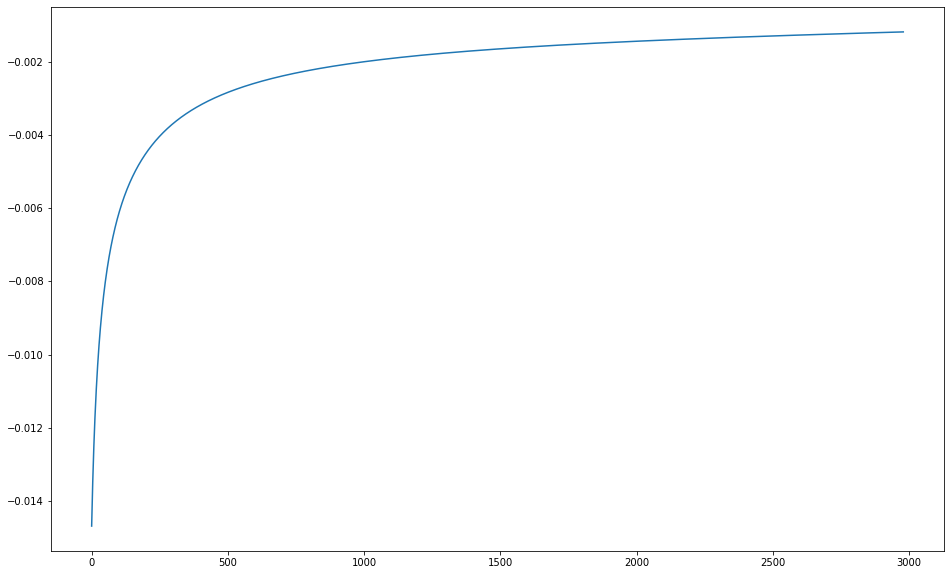

In [ ]:
plt.figure(figsize= (16,10))
plt.plot(resp[20:])

In [ ]:
        t = 0
        g = 1
        if h==0:
            h = 1
        elif h<0:
            t = 1
            g = 0
        bc = c[ny-top_left[0]-g*h-1:ny-top_left[0]-t*h+1, top_left[1]-s-w-d-w-1:top_left[1]-s-w-d+1]

        #bottom cathode
        tc = c[bottom_right[0]+t*h-1:bottom_right[0]+g*h+1, bottom_right[1]+s+w+d-1:bottom_right[1]+s+w+d+w+1] 



        integr = tc.sum() - bc.sum()
    print('integration {0:.2f}: {1:.7f} '.format(freq,  integr))
    resp.append(integr)
    print(resp)